In [5]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [8]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [9]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])


# Apply augmentation to the training data
def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



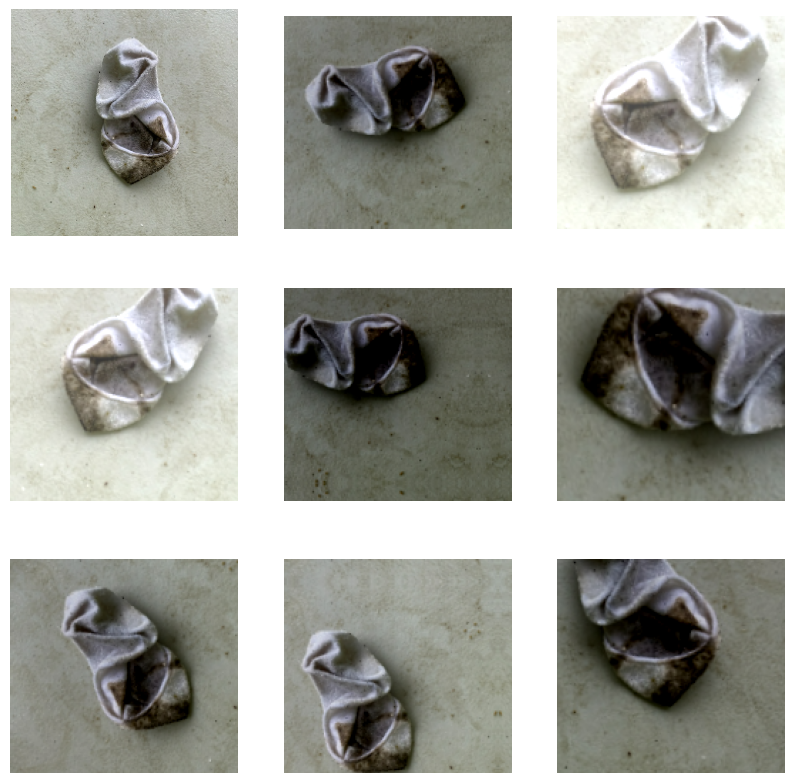

In [10]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [11]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label




In [12]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [13]:
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)

val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)

In [14]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


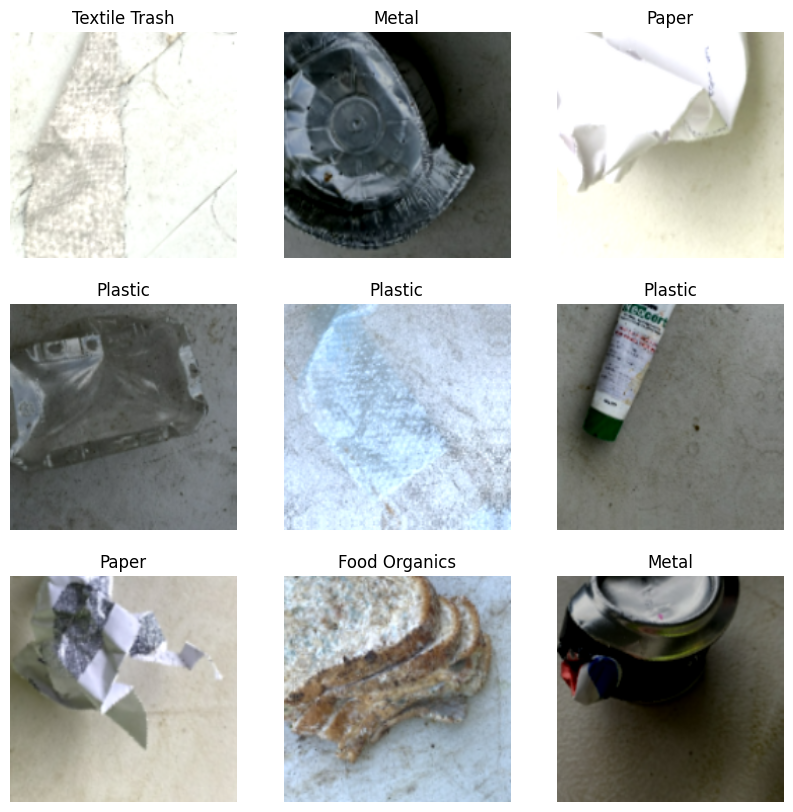

In [15]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

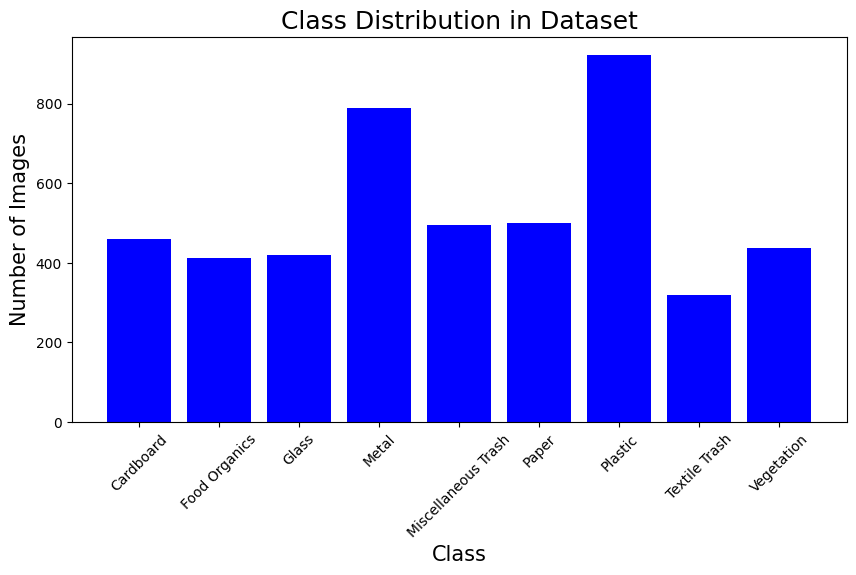

In [16]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [17]:
label_counter = Counter()
for _, label in train_dataset.unbatch().as_numpy_iterator():
    label = np.array(label)
    if label.size == 1:
        label = label.item()
    else:
        label = int(np.argmax(label))
    label_counter[int(label)] += 1

# Step 4: Identify underrepresented classes (e.g., below median)
counts = np.array(list(label_counter.values()))
median_count = np.median(counts)
low_classes = [cls for cls, count in label_counter.items() if count < median_count]
low_class_tensor = tf.constant(low_classes, dtype=tf.int64)
print("Low-frequency classes:", low_classes)

def is_low_class(image, label):
    label = tf.cast(tf.argmax(label, axis=-1), tf.int64)
    return tf.reduce_any(tf.equal(label, low_class_tensor))

def extra_augment(image, label):
    image = tf.image.rot90(image)
    image = tf.image.random_saturation(image, 0.6, 1.4)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.cast(label, tf.int32), 9)
    return image, label

low_class_augmented = train_dataset.unbatch().filter(is_low_class).map(extra_augment).map(normalize_img).batch(32).prefetch(tf.data.AUTOTUNE)


# Step 6: Combine both into final training set


final_train_dataset = train_dataset.concatenate(low_class_augmented).unbatch().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


Low-frequency classes: [1, 2, 7, 8]


In [18]:
print("Class distribution after final augmentation:")
label_counter = Counter()

for _, labels in final_train_dataset.unbatch().take(1000):
    label = labels.numpy()
    if label.shape == (9,):  # one-hot
        label_idx = np.argmax(label)
        label_counter[int(label_idx)] += 1

print(dict(label_counter))



Class distribution after final augmentation:
{7: 63, 6: 196, 3: 168, 0: 96, 8: 81, 5: 121, 4: 101, 2: 80, 1: 94}


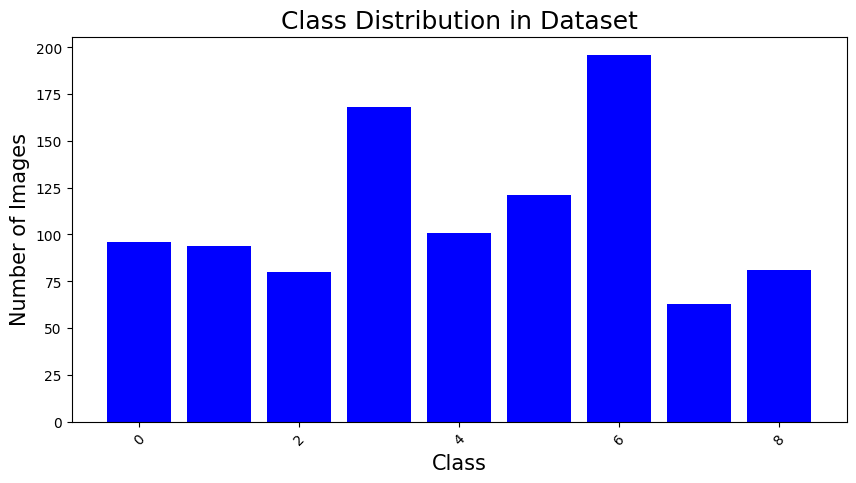

In [19]:


# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(label_counter.keys(), label_counter.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [20]:
# Class weights computation
train_labels = []
for _, label in final_train_dataset.unbatch().take(1000):  # Limit for speed/safety
    label = label.numpy()
    while label.ndim > 1:
        label = np.mean(label, axis=0)
    if label.ndim == 1 and label.shape[0] == 9:
        class_idx = int(np.argmax(label))
        train_labels.append(class_idx)

train_labels = np.array(train_labels)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.arange(9), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)


Class weights: {0: np.float64(1.1574074074074074), 1: np.float64(1.3550135501355014), 2: np.float64(1.6103059581320451), 3: np.float64(0.6313131313131313), 4: np.float64(1.1574074074074074), 5: np.float64(1.0482180293501049), 6: np.float64(0.531632110579479), 7: np.float64(1.5649452269170578), 8: np.float64(1.1695906432748537)}


In [21]:

def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal loss for multi-class classification with one-hot labels.
    """
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)

    return loss

In [22]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model



# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss= categorical_focal_loss(alpha=1, gamma=2),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor="val_loss",  # Monitor the validation loss
                               patience=3,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best model weights when stopping
                               verbose=1)  # Print messages when stopping

history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, callbacks=[early_stopping])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.0989 - loss: 2.0257 - val_accuracy: 0.0384 - val_loss: 1.7481
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 82s 788ms/step - accuracy: 0.1082 - loss: 1.9580 - val_accuracy: 0.0909 - val_loss: 1.7465
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 727ms/step - accuracy: 0.1078 - loss: 1.8906 - val_accuracy: 0.0710 - val_loss: 1.7450
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 680ms/step - accuracy: 0.0950 - loss: 1.9320 - val_accuracy: 0.0554 - val_loss: 1.7378
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 672ms/step - accuracy: 0.1088 - loss: 1.9214 - val_accuracy: 0.0838 - val_loss: 1.7429
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 83s 687ms/step - accuracy: 0.0841 - loss: 1.9125 - val_accuracy: 0.1009 - val_loss: 1.7435
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 655ms/step - accuracy: 0.1003 - loss: 1.9288 - val_accuracy: 0.1151 - val_loss: 1.7320
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━

In [23]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [24]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00       110
           4       0.12      0.96      0.21        82
           5       0.38      0.06      0.11        82
           6       0.00      0.00      0.00       139
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00        73

    accuracy                           0.12       704
   macro avg       0.06      0.11      0.03       704
weighted avg       0.06      0.12      0.04       704



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:20]:  # Freeze first 100 layers
    layer.trainable = True

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss= categorical_focal_loss(alpha=1, gamma=2),
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weights_dict, )

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 162s 703ms/step - accuracy: 0.1064 - loss: 2.6819 - val_accuracy: 0.1136 - val_loss: 2.0879
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 95s 681ms/step - accuracy: 0.1533 - loss: 2.2974 - val_accuracy: 0.1278 - val_loss: 2.1028
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 84s 698ms/step - accuracy: 0.1908 - loss: 2.0615 - val_accuracy: 0.1293 - val_loss: 2.0960
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 668ms/step - accuracy: 0.2372 - loss: 1.8417 - val_accuracy: 0.1605 - val_loss: 1.9282
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 85s 700ms/step - accuracy: 0.2631 - loss: 1.7523 - val_accuracy: 0.2599 - val_loss: 1.5474
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 79s 669ms/step - accuracy: 0.2853 - loss: 1.6188 - val_accuracy: 0.3452 - val_loss: 1.3962
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 71s 679ms/step - accuracy: 0.3141 - loss: 1.5171 - val_accuracy: 0.3239 - val_loss: 1.3728
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 73s 700ms/step - accuracy: 0.3348 - loss: 

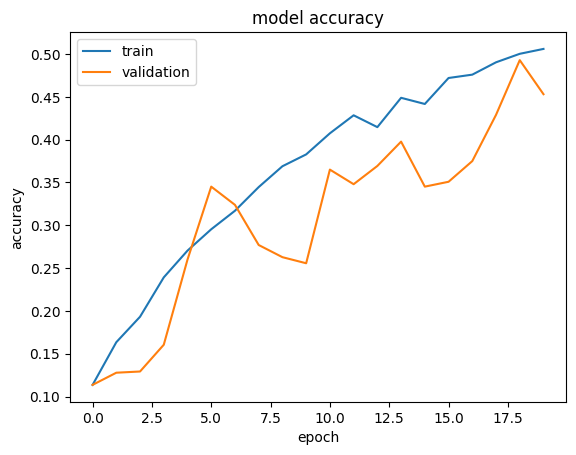

In [27]:
def plot_hist(history_fine_tune):
    plt.plot(history_fine_tune.history["accuracy"])
    plt.plot(history_fine_tune.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history_fine_tune)

In [28]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.43      0.33        46
           1       0.44      0.63      0.52        51
           2       0.40      0.27      0.32        66
           3       0.58      0.45      0.50       119
           4       0.27      0.34      0.30        83
           5       0.51      0.58      0.54        78
           6       0.57      0.27      0.36       142
           7       0.53      0.60      0.56        48
           8       0.50      0.76      0.60        71

    accuracy                           0.45       704
   macro avg       0.45      0.48      0.45       704
weighted avg       0.47      0.45      0.44       704



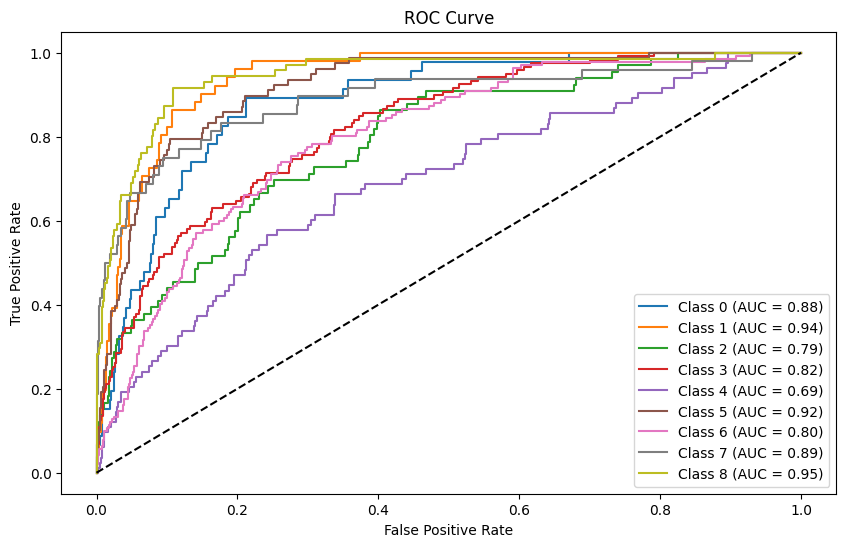

In [30]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

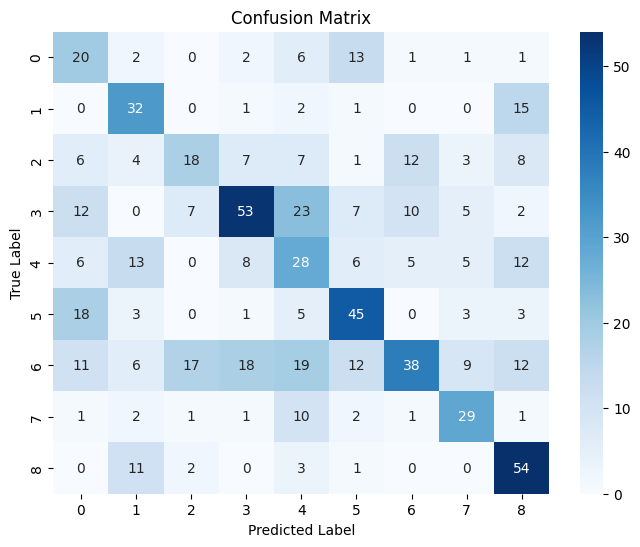

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:



def build_model(hp):
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = hp.Boolean('trainable', default=False)  # Fine-tuning option

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)),
        layers.Dense(hp.Int("units", min_value=128, max_value=512, step=64), activation="relu"),
        layers.Dense(9, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-4, 1e-5, 1e-6])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)


In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=10)

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Best Learning Rate: {best_hp.get('learning_rate')}")
print(f"Best Dropout Rate: {best_hp.get('dropout_rate')}")
print(f"Best Number of Units: {best_hp.get('units')}")
print(f"Trainable Base Model: {best_hp.get('trainable')}")


In [ ]:
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=20)


In [ ]:
tuner.results_summary()


In [ ]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
